![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

このnotebookは， [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme)の入門チュートリアルです．ネイティブのPythonバインディングを使用しています。

**CPUのみのランタイムを使用している場合**は、メニューの "Runtime > Change runtime type "で切り替えることができます。










### 著作権について

> <p><small><small>Copyright 2022 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Install MuJoCo

In [ ]:
!pip install mujoco

In [4]:
#@title インストールが成功したかどうかを確認する

# from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode: #GPUが利用可能かどうかを確認します。subprocess.run('nvidia-smi').returncode は、nvidia-smiコマンドを実行し、その戻り値を取得しています。もしGPUが利用できない場合はエラーが発生します。
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

try:
  print('mujocoのインストールが成功しているか確認します')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>') #超単純なxmlを読み込ませ，エラーが出ないか確かめる
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('インストールは成功していました.')

mujocoのインストールが成功しているか確認します
インストールは成功していました.


In [ ]:
#Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
# コードの意味
# np.set_printoptions: これはNumPyの関数であり、NumPyのデフォルトの出力オプションを変更します。
# precision=3: 小数点以下の桁数を3桁に設定します。つまり、浮動小数点数は3桁まで表示されます。
# suppress=True: 指数表記を抑制します。通常、非常に大きな数や非常に小さな数は指数表記で表示されますが、このオプションをTrueに設定することで、通常の小数形式で表示されます。
# linewidth=100: 1行に表示される文字の最大数を100文字に設定します。これにより、行が長すぎて読みにくくなるのを防ぎます。
# つまり、このコードは、NumPyを使用する際に出力される浮動小数点数のフォーマットを設定し、より読みやすい形式で表示するためのものです。

# MuJoCoの基本

まず、簡単なモデルを定義し、ロードすることから始めます：

In [6]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

以下はMuJoCo公式チュートリアルの一部の日本語訳です：


`xml`文字列はMuJoCoの[ MJCF ](http://www.mujoco.org/book/modeling.html)形式で書かれており、これは[XML](https://en.wikipedia.org/wiki/XML#Key_terminology)ベースのモデリング言語です。
  - 唯一必須の要素は `<mujoco>` です。最小の有効なMJCFモデルは `<mujoco/>` であり、完全に空のモデルです。
  - すべての物理要素は常にトップレベルのボディであり、デカルト座標系におけるグローバルオリジンを構成する `<worldbody>` 内に存在します。
  - 我々は `red_box` と `green_sphere` という名前の二つの形状を定義しています。
  - **質問:** `red_box` には位置がありませんし、`green_sphere` にはタイプがありません。それはなぜですか？
    - **回答:** MJCFの属性には *デフォルト値* があります。デフォルトの位置は `0 0 0` であり、デフォルトのジオムタイプは `sphere` です。MJCF言語の詳細はドキュメンテーションの[XMLリファレンス章](https://mujoco.readthedocs.io/en/latest/XMLreference.html)で説明されています。

`from_xml_string()` メソッドはモデルコンパイラを呼び出し、バイナリの `mjModel` インスタンスを作成します。

## mjModel

MuJoCoの `mjModel` は*モデルの記述*を含みます。つまり、*時間経過によって変化しない*すべての数量が含まれています。`mjModel`の完全な説明はヘッダファイル [`mjmodel.h`](https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjmodel.h) の最後にあります。ヘッダファイルには各フィールドを説明する短い有用なインラインコメントが含まれていることに注意してください。

`mjModel`で見つかる数量の例としては、`ngeom`（シーン内のジオムの数）やそれぞれの色を示す `geom_rgba` があります。

In [7]:
model.ngeom

2

In [8]:
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

## Named access (指名アクセス?)

MuJoCoのPythonバインディングは、名前を使用した便利な[アクセサ](https://mujoco.readthedocs.io/en/latest/python.html#named-access)を提供します。名前文字列なしで `model.geom()` アクセサを呼び出すと、有効な名前が何かを教えてくれる便利なエラーが生成されます。

In [9]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


特定のプロパティを指定せずに名前付きアクセサを呼び出すと、すべての有効なプロパティが表示されます  
(つまり，ただ名前を指定してmodel.geomを実行すると，どんな機能があるかを一覧表示してくれる？)

In [10]:
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0])
  conaffinity: array([1])
  condim: array([3])
  contype: array([1])
  dataid: array([-1])
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0])
  id: 1
  margin: array([0.])
  matid: array([-1])
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0])
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2])
  user: array([], dtype=float64)
>

それでは `green_sphere`'の色情報であるrgba値を見ていきましょう:
（さっき一覧表示した中のrgbaオプション（プロパティ？）を使ってみるという場面）

In [11]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

以下の機能は、MuJoCoの[`mj_name2id`](https://mujoco.readthedocs.io/en/latest/APIreference.html?highlight=mj_name2id#mj-name2id)関数の便利なショートカットです：

In [12]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

同様に、読み取り専用の `id` と `name` プロパティは、idから名前への変換やその逆を行うのに使用できます：
（mujocoで物体を指定する場合，その物体を定義するときにつけた名前でも指定できるし，idでも指定できる．名前とidを相互変換できる機能がある）

In [13]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  1
name of geom 1:  green_sphere
name of body 0:  world


0番目のボディは常に `world` です。これは名前を変更できません。

`id` および `name` 属性はPythonの内包表記で便利です：
（内包表記で，一文でmodel内のgeomの名前を一覧表示するプログラムの紹介）

In [15]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

## `mjData`
`mjData` は*状態*とそれに依存する量を含んでいます。状態は時間、[一般化座標](https://en.wikipedia.org/wiki/Generalized_coordinates)、一般化速度で構成されています。それぞれ `data.time`、`data.qpos`、および `data.qvel` です。新しい `mjData` を作成するには、`mjModel` があれば十分です。

In [16]:
data = mujoco.MjData(model)

`mjData` には状態の*関数*も含まれており、例えばワールドフレーム内のオブジェクトの直交座標が含まれます。我々の二つの形状の(x, y, z)位置は `data.geom_xpos` に格納されています：

In [17]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


待ってください。なぜ私たちの二つの形状が両方とも原点にあるのですか？緑色の球体をオフセットしなかったのではないですか？答えは、`mjData`内の派生量は明示的に伝播する必要があるということです（[以下を参照](#scrollTo=QY1gpms1HXeN)）。私たちの場合、最小限に必要な関数は[`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics)です。これはすべてのオブジェクトのグローバルな直交座標を計算します．カメラやライトは除きます。
（赤い立方体と緑の玉がありましたが，なぜ上では両方とも座標が0,0,0なのか？それは，～～～（まだよくわかってない））

In [18]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# 基本的なレンダリング、シミュレーション、アニメーション

レンダリングを行うには、`Renderer` オブジェクトをインスタンス化し、その `render` メソッドを呼び出す必要があります。

また、Colabのセクションを独立させるために、モデルを再読み込みします。

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
media.show_image(renderer.render())

うーん、なぜ黒いピクセルが表示されるのでしょうか？

**回答:** 先ほどと同じ理由で、まずは `mjData` 内の値を伝播させる必要があります。今回は [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward) を呼び出します。これは加速度の計算までのパイプライン全体を呼び出します。つまり、$\dot x = f(x)$ を計算します。ここで $x$ は状態を表します。この関数は実際には必要以上のことをしますが、計算時間を節約することに興味がない限り、`mj_forward` を呼び出すのが良い習慣です。そうすれば、何か重要な部分を見逃していないかがわかります。

また、レンダラーが持っているビジュアルシーンを記述する `mjvScene` を更新する必要があります。後で物理モデルの一部ではないビジュアルオブジェクトを含む場合があることを見ていきます。

""

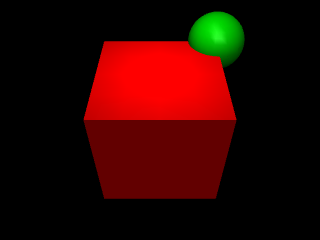

In [3]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

これはうまくいきましたが、この画像は少し暗いですね。では、ライトを追加して再レンダリングしましょう。

""

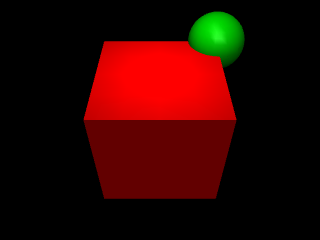

In [2]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

とても良くなりました！

`mjModel` インスタンス内のすべての値は書き込み可能です。一般的にはXML内の値を変更する方が推奨されますが、無効なモデルになる可能性があるため、注意が必要です。ただし、一部の値は安全に書き込むことができます。例えば、色です：

In [1]:
# Run this cell multiple times for different colors
model.geom('red_box').rgba[:3] = np.random.rand(3)
renderer.update_scene(data)
media.show_image(renderer.render())

NameError: name 'np' is not defined

# シミュレーション

さて、シミュレーションを行ってビデオを作成しましょう。MuJoCoの主要な高レベル関数である `mj_step` を使用します。これは状態を1ステップ進めます $x_{t+h} = f(x_t)$。

以下のコードブロックでは、`mj_step` を呼び出した後に毎回レンダリングは行いません。これはデフォルトのタイムステップが2msであり、60fpsのビデオを作成したいためです。500fpsではないためです。

In [ ]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

うーん、ビデオは再生されていますが、何も動いていませんね。なぜでしょうか？

これはこのモデルには[自由度（degrees of freedom）](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics))（DoFs）がないためです。動くもの（および慣性を持つもの）は*ボディ*と呼ばれます。私たちは*ボディ*に*ジョイント*を追加して、それらが親に対してどのように動くかを指定します。新しいボディを作成し、その中に私たちの形状を含め、ヒンジジョイントを追加して再レンダリングし、可視化オプションオブジェクト `MjvOption` を使用してジョイント軸を可視化しましょう。

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

注意してください、`box_and_sphere` ボディをZ軸（垂直軸）を中心に30°回転させました。これは、要素の姿勢が常にそれらの*親ボディ*に対して行われることを強調するためです。そのため、私たちの二つの形状もこの変換によって回転しました。

物理オプションは `mjModel.opt` にあります。例えば、タイムステップは以下の通りです：

In [ ]:
model.opt.timestep

重力を反転させて再度レンダリングしましょう：

In [ ]:
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=60)

これはXMLを使用しても同様に行うことができます。トップレベルの `<option>` 要素を使用します：

```xml
<mujoco>
  <option gravity="0 0 10"/>
  ...
</mujoco>
```

### 自由度の理解

実世界では、すべての剛体オブジェクトは6つの自由度を持っています：3つの平行移動と3つの回転です。実世界のジョイントは制約として機能し、ジョイントで接続されたボディ間の相対的な自由度を削除します。一部の物理シミュレーションソフトウェアは、これを「カーテシアン」または「減算」表現として使用しますが、これは効率的ではありません。MuJoCoは、「ラグランジアン」、「一般化」または「加算」表現として知られる表現を使用します。この表現では、オブジェクトは明示的にジョイントを使用して追加しない限り、自由度を持ちません。

私たちのモデルは、単一のヒンジジョイントを持っており、1つの自由度を持っています。全体の状態は、このジョイントの角度と角速度で定義されます。これらがシステムの一般化された位置と速度です。

In [ ]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

MuJoCoが一般化座標を使用する理由は、関数を呼び出す（例: [`mj_forward`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-forward)）必要があるのは、オブジェクトのグローバルな姿勢をレンダリングしたり読み取ったりする前に、データを準備する必要があるからです - カーテシアン座標は一般化座標から*派生*し、明示的に計算する必要があります。

# 例: 自由なボディをシミュレートして自己反転する "tippe-top"

自由なボディは、6つの自由度、つまり3つの移動と3つの回転を持つ[自由ジョイント](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint)を持つボディです。私たちは `box_and_sphere` ボディに自由なジョイントを与えて落ちる様子を見ることもできますが、もう少し面白いものを見てみましょう。"tippe top"は、自分自身を反転させる回転するおもちゃです（[動画](https://www.youtube.com/watch?v=kbYpVrdcszQ)、[Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)）。これを以下のようにモデル化します：

In [ ]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

このモデル定義のいくつかの新機能に注意してください：
1. 6自由度の自由ジョイントが `<freejoint/>` 句で追加されています。
2. 4次の[ルンゲ・クッタ法](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)が演算に使用されるように、積分器を設定するために `<option/>` 句を使用しています。ルンゲ・クッタ法はデフォルトのオイラー積分器よりも収束率が高く、多くの場合、与えられたタイムステップサイズでの精度が向上します。
3. フロアのグリッド素材を `<asset/>` 句内で定義し、それを "floor" ジオムで参照しています。
4. `ballast` という名前の見えない非衝突ボックスジオムを使用して、トップの重心を下げています。低い重心を持つことは（直感に反して）反転動作が発生するために必要です。
5. 最初の回転状態を*キーフレーム*として保存しています。これはZ軸周りに高い回転速度を持っていますが、完全にワールドに向き合っていないため、反転に必要な対称性の破れを導入します。
6. モデル内で `<camera>` を定義し、それを使用して `update_scene()` の `camera` 引数からレンダリングします。

状態を調べてみましょう：

In [ ]:
print('positions', data.qpos)
print('velocities', data.qvel)

速度は解釈しやすいですね、6つのゼロがあります、それぞれが1つの自由度に対応しています。では、長さ7の位置はどうでしょうか？最初の2cmの高さが見えます。その後の4つの数字は3Dの向きを示しており、*ユニット四元数*で定義されています。3Dの向きは**4**つの数字で表され、角速度は**3**つの数字です。詳細については、ウィキペディアの[四元数と空間回転](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation)の記事を参照してください。

さて、ビデオを作成しましょう：

In [ ]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

### `mjData` からの値の計測
先述の通り、`mjData` 構造体にはシミュレーションによって生成される動的な変数や中間結果が含まれており、これらは各タイムステップで*変化することが期待されています*。以下では、2000のタイムステップのシミュレーションを行い、トップの角速度とステムの高さを時間の関数としてプロットします。

In [ ]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2]);

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')

# Example: A chaotic pendulum

Below is a model of a chaotic pendulum, similar to [this one](https://www.exploratorium.edu/exhibits/chaotic-pendulum) in the San Francisco Exploratorium.

In [ ]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
renderer = mujoco.Renderer(model, 480, 640)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="fixed")
media.show_image(renderer.render())

## Timing
Let's see a video of it in action while we time the components:

In [ ]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
renderer = mujoco.Renderer(model, 240, 320)


# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10


# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
for i in range(n_frames):
  while data.time * framerate < i:
    tic = time.time()
    mujoco.mj_step(model, data)
    sim_time += time.time() - tic
    n_steps += 1
  tic = time.time()
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  render_time += time.time() - tic
  frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

Note that rendering is **much** slower than the simulated physics.

## Chaos
This is a [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) system (small pertubations in initial conditions accumulate quickly):

In [ ]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

## Timestep and accuracy
**Question:** Why is the energy varying at all? There is no friction or damping, this system should conserve energy.

**Answer:** Because of the discretization of time.

If we decrease the timestep we'll get better accuracy and better energy conservation:

In [ ]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

## Timestep and divergence
When we increase the time step, the simulation quickly diverges:

In [ ]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
  # set timestep
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 11 # set root joint velocity

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    if data.warning.number.any():
      warning_index = np.nonzero(data.warning.number)[0]
      warning = mujoco.mjtWarning(warning_index).name
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')
      break
    sim_time[i] = data.time
    energy[i] = sum(abs(data.qvel))
    speed[i] = np.linalg.norm(data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')


# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()


# Contacts

Let's go back to our box and sphere example and give it a free joint:

In [ ]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
renderer = mujoco.Renderer(model, 400, 600)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fixed")
media.show_image(renderer.render())

Let render this body rolling on the floor, in slow-motion, while visualizing contact points and forces:

In [ ]:
n_frames = 200
height = 240
width = 320
frames = []
renderer = mujoco.Renderer(model, height, width)

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# simulate and render
for i in range(n_frames):
  while data.time < i/120.0: #1/4x real time
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "track", options)
  frame = renderer.render()
  frames.append(frame)

# show video
media.show_video(frames, fps=30)

## Analysis of contact forces

Let's rerun the above simulation (with a different random initial condition) and
plot some values related to the contacts

In [ ]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()

## Friction

Let's see the effect of changing friction values

In [ ]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height, width)

# simulate and render
mujoco.mj_resetData(model, data)
for i in range(n_frames):
  while data.time < i/30.0:
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "y")
  frame = renderer.render()
  frames.append(frame)
media.show_video(frames, fps=30)

# Tendons, actuators and sensors

In [ ]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
renderer = mujoco.Renderer(model, 480, 480)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fixed")
media.show_image(renderer.render())


actuated bat and passive "piñata":

In [ ]:
n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

renderer = mujoco.Renderer(model, height, width)

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# simulate and render
for i in range(n_frames):
  while data.time < i/fps:
    mujoco.mj_step(model, data)
    times.append(data.time)
    sensordata.append(data.sensor('accelerometer').data.copy())
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  frames.append(frame)

media.show_video(frames, fps=fps)

Let's plot the values measured by our accelerometer sensor:

In [ ]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced rendering

Like joint visualization, additional rendering options are exposed as parameters to the `render` method.

Let's bring back our first model:

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [ ]:
#@title Enable transparency and frame visualization

scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
renderer.update_scene(data, scene_option=scene_option)
frame = renderer.render()
media.show_image(frame)

In [ ]:
#@title Depth rendering

# update renderer to render depth
renderer.enable_depth_rendering()

# reset the scene
renderer.update_scene(data)

# depth is a float array, in meters.
depth = renderer.render()

# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)

media.show_image(pixels.astype(np.uint8))

renderer.disable_depth_rendering()

In [ ]:
#@title Segmentation rendering

# update renderer to render segmentation
renderer.enable_segmentation_rendering()

# reset the scene
renderer.update_scene(data)

seg = renderer.render()

# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
media.show_image(pixels.astype(np.uint8))

renderer.disable_segmentation_rendering()

## The camera matrix

For a description of the camera matrix see the article [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) on Wikipedia.

In [ ]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

Let's use the camera matrix to project from world to camera coordinates:

In [ ]:
# reset the scene
renderer.update_scene(data)


# Get the world coordinates of the box corners
box_pos = data.geom_xpos[model.geom('red_box').id]
box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
box_size = model.geom_size[model.geom('red_box').id]
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(list(itertools.product(*offsets))).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
m = compute_camera_matrix(renderer, data)

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = m @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = renderer.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()

## Modifying the scene

Let's add some arbitrary geometry to the `mjvScene`.

In [ ]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/8  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

while data.time < duration:
  # append data to the traces
  positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
  times.append(data.time)
  speeds.append(get_geom_speed(model, data, "green_sphere"))
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    modify_scene(renderer.scene)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)